## Active Learning Research


Current baseline :

In [44]:
from transformers import (AutoModelForSequenceClassification,
                          AutoModel,
                          AutoTokenizer)
from utils import create_datasets
from tqdm.notebook import tqdm
import numpy as np
import evaluate
import seaborn as sns
import pandas as pd
tqdm.pandas()

In [22]:
from transformers import (AutoModelForSequenceClassification, AutoTokenizer)
from utils import create_datasets
import torch


MODEL = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(MODEL) ## tokenizer baseline
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2, state_dict=torch.load("./models/checkpoint-8750/model.pt", map_location=torch.device('cpu')))## trained baseline


ds = create_datasets(2_000) # 10_000 samples for simple study

In [ ]:
softmax = lambda x : np.exp(x) / np.exp(x).sum()
lgts = []
for sample in tqdm(ds):
    label = sample.pop("labels")
    pred = model(**tok(sample["tweet"], truncation=True, padding="max_length", max_length=512, return_tensors="pt")).logits.detach().numpy()
    H = np.sum(- softmax(pred) * np.log(softmax(pred)))
    lgts.append([pred, label, H])

Text(0, 0.5, 'Number of samples in the EDA subselection')

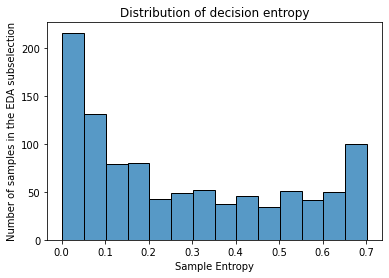

In [48]:
preds, labels, Hs = zip(*lgts)

LGTS = pd.DataFrame({
    "preds": preds,
    "labels": labels,
    "H": Hs
})

g = sns.histplot(data=LGTS, x="H", binwidth=0.05)
g.set_title("Distribution of decision entropy")
g.set_xlabel("Sample Entropy")
g.set_ylabel("Number of samples in the EDA subselection");

In [67]:
## accuracy
ACC = (LGTS.labels.values == np.vstack(list(LGTS.preds.values)).argmax(axis=1)).sum() / LGTS.labels.values.shape[0]
print("The accuracy is : ", round(ACC, 2))

The accuracy is :  0.86


In [69]:
ppl = evaluate.load("perplexity")

ppls = ppl.compute(predictions=ds["tweet"][:len(LGTS.index)], model_id="gpt2")

Using pad_token, but it is not set yet.


  0%|          | 0/64 [00:00<?, ?it/s]

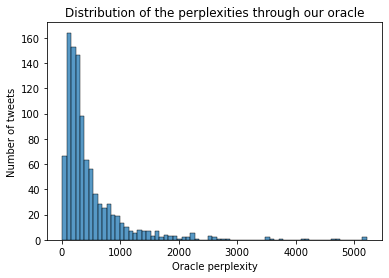

In [72]:
LGTS["PPLS"] = ppls["perplexities"]

g = sns.histplot(data=LGTS, x="PPLS")
g.set_title("Distribution of the perplexities through our oracle")
g.set_xlabel("Oracle perplexity")
g.set_ylabel("Number of tweets");

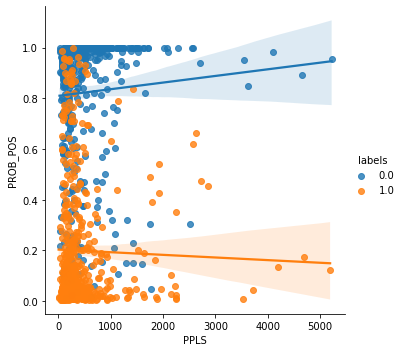

In [89]:
g = sns.lmplot(data=LGTS, x="PPLS", y="PROB_POS", hue="labels")

<Axes: xlabel='PROB_POS', ylabel='Count'>

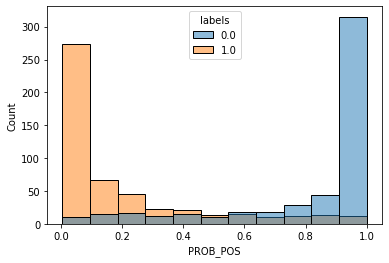

In [90]:
sns.histplot(data=LGTS, x="PROB_POS", hue="labels")

In [88]:
from scipy.stats import pearsonr
LGTS["PROB_POS"] = LGTS["preds"].apply(lambda x : softmax(x)[0][0])
pearsonr(LGTS["PPLS"], LGTS["PROB_POS"])

PearsonRResult(statistic=0.05631727303377048, pvalue=0.07361569694688039)

In [76]:
LGTS["tweet"] = ds["tweet"][:len(LGTS.index)]

In [79]:
display("Minimum PPL")
display(LGTS.sort_values("PPLS", ascending=True).head(5))
display("Maximum PPL")
display(LGTS.sort_values("PPLS", ascending=False).head(5))
display("Minimum H")
display(LGTS.sort_values("H", ascending=True).head(5))
display("aximum H")
display(LGTS.sort_values("H", ascending=False).head(5))

'Minimum PPL'

,preds,labels,H,PPLS,tweet
488,"[[-2.242605, 1.9175991]]",1.0,0.079404,7.243697,<user> <user> <user> <user> <user> <user> <use...
30,"[[-2.2488852, 2.030917]]",1.0,0.072197,14.437491,<user> <user> <user> <user> <user> congrats guys
391,"[[2.0828052, -2.4751933]]",0.0,0.057714,24.068689,i don't want to get up
270,"[[-0.62615865, 0.34240225]]",0.0,0.588331,29.650576,"i need you by my side the rest of my life , i ..."
103,"[[-1.2375259, 1.1255263]]",1.0,0.293264,33.084122,<user> i would if i didnt have to write a pape...


'Maximum PPL'

,preds,labels,H,PPLS,tweet
1000,"[[1.4862301, -1.617888]]",0.0,0.177171,5218.961914,left fone charger at work by world xx
608,"[[-1.1633459, 0.79933023]]",1.0,0.373209,5189.971191,23 shots on coyotess . cmon blackhawkkkss
1006,"[[-0.87279934, 0.6746565]]",1.0,0.464430,4699.214355,<user> at dairy queen in cornersburg .
283,"[[0.91879606, -1.1939349]]",0.0,0.342029,4653.928711,eewww have math after :/
474,"[[-1.0633569, 0.8005994]]",1.0,0.394373,4191.298828,200 shells later .. tired but happy


'Minimum H'

,preds,labels,H,PPLS,tweet
448,"[[3.8450773, -4.770585]]",0.0,0.001743,162.045441,friendcaster pro for facebook 5.0 . 3 ( v5 . 0...
631,"[[3.828224, -4.7759757]]",0.0,0.001761,1009.406738,pelican 1495 case with foam ( desert tan this ...
145,"[[3.8178346, -4.784987]]",0.0,0.001763,776.526978,03x34 custom picture frame / poster frame 1.26...
140,"[[3.8214154, -4.7752347]]",0.0,0.001772,809.300537,15x17 custom picture frame / poster frame 2.37...
31,"[[3.8273973, -4.763286]]",0.0,0.001782,858.332886,new kv-s 2028c - j dplxscn 24/10 ppm col usb 2...


'aximum H'

,preds,labels,H,PPLS,tweet
593,"[[-0.169229, -0.16305009]]",1.0,0.693142,164.043243,""" <user> <user> omg , is that my biatch ? ? wh..."
731,"[[-0.112079166, -0.12318482]]",0.0,0.693132,899.016602,<user> really ? ! bigger name than snsd ? ikr ...
769,"[[-0.04596198, -0.06468097]]",1.0,0.693103,263.883728,i accidentally typed instead of and now it's a...
335,"[[-0.1795977, -0.15888764]]",1.0,0.693094,306.322052,<user> whats my score ? and my current place ?...
825,"[[-0.10888206, -0.14099534]]",0.0,0.693018,308.676880,i wanna eat the birthday cake now <url>


In [42]:
import pickle

with open("EDA_SUB.pkl", 'wb') as f:
    pickle.dump(ds, f)

with open("EDA_PREDS.pkl", "wb") as f:
    pickle.dump(lgts, f)


# with open("ppls.pkl", 'wb') as f:
#     pickle.dump(ppls, f)

### Theory

Let the perplexity 
$$
PPL(x) = 2^{H_{\mathcal{O}}(x)} = 2^{- \sum_{x}p(x)log_2(p(x))}
$$

- $H_{\mathcal{O}}(x)$ : the "ground truth" perplexity of a sample. For very strong model consider this being the "predicability" of a sample.
- $H(x)$ : the entropy of this same sample through one of our classification model. The latter being significantly smaller than the *"Oracle"* model

Try to find a correlation between $PPL : x \rightarrow 2^{H_{\mathcal{O}}(x)}$ and $H(x)$, the entropy of the prediction.


If we have a significant similarity we could compute $\{H_{\mathcal{O}}(x) : x \in \mathcal{X}\}$, where X is the total set. We'll have a *"a priori"* measure of unpredictability measure that we could use to generate the first set $\mathcal{S}$ of start samples.

---

- Iteration 0 : Select a subset $\mathcal{S}_0 \subset \mathcal{X}$ of the training samples. Compute the prediction set $\mathcal{P}_0 = \{ \mathcal{M}(x), x \in \mathcal{S}_0 \}$.
- Iteration 1 : Select all the predictions that have an entropy above the median $m_1$, $\mathcal{S}_1$ = $\{x : H(\mathcal{M}(x)) > m_1, \forall x \in \mathcal{P}_0\}$ and feed it into the model.\
[...]
- Iteration k : Select all the predictions that have an entropy above the median $m_k$, $\mathcal{S}_k$ = $\{x : H(\mathcal{M}(x)) > m_k,  \forall x \in \mathcal{P}_{k-1}\}$ and feed it into the model.
- Stop whenever $|\mathcal{P}_i| \leq T$, for $T$ a selected threshold.


Number of predictions to do at iter 1 is $\mathcal{O}(|\mathcal{S_0}|)$, at iter 2 : $\mathcal{O}(|\mathcal{S_0}| / 2)$, ..., at iter $k$ : $\mathcal{O}(|\mathcal{S_0}| / 2^k)$.

$$

|\mathcal{S_0}| / 2^k = T \\

\iff k = log_2(|\mathcal{S}_0| / T)
$$

We'll do $N = \mathcal{O}(log(|\mathcal{S}_0| / T))$ iterations. with overall number of prediction $\mathcal{R}$ of 

$$
    \mathcal{R} = |\mathcal{S}_0| \sum_{i=1}^N 2^{-i} \ 
    = |\mathcal{S}_0| \frac{2^{-N} - 1}{2^{-(N+1)} - 1} \ 
    <  |\mathcal{S}_0| \sum_{i=1}^{+ \infty} 2^{-i} = 2|\mathcal{S}_0|
$$

The runtime is clearly overbounded by 2 full epochs on $\mathcal{S}_0$.

So it's equivalent of doing two epochs but better. The argument is that low entropy samples are not even needed since BERT is pretrained and the samples are really simple to classify. The model doesn't even need to see it. We would like to see only high entropy samples. Neverthless we have not third party measure of the entropy and need to do a first batch of classification over the whole set. The model has trained once on the easy samples (which is enough for the model to learn the decision concept). Now we retrained at epoch 2 on the samples hard to classify. The models learn to fine tune the decision boundary without even considering the samples that are far away from the decision boundary. For a reasnobale threshold the runtime is upperbounded by 2 whole epochs on the whole set but we'll be significantly lower for an accuracy that should be near to identical.

<ins>Merge between Dasgupta + entropy</ins>

---

Implement Dasgupta

According to the missclassification.
threshold T is selection from an exponential distribution $\mathcal{T} \sim exp(ln(|\mathcal{X}|/\delta))$
- Iter k : Start with $\mathcal{S}_0 \subset \mathcal{X}$ and initiaze $W = \{w(x) : x \in \mathcal{S_0}\}$, compute $\mathcal{P}_k = \{\mathcal{M}(x), x \in \mathcal{S}_{k-1}\}$        
    Compute the misslclassif : $\Delta(\mathcal{M}) = \{ x \in \mathcal{X} : \mathcal{M}(x) \neq L_x\}$ where $L_x$ the label of $x$.
    
    If $|\Delta(\mathcal{M})| = 0$ then accept the model
    
    while $\sum_{x \in \mathcal{S}_i} w(x) < 1$: 
    - Double each $w(x)$ for $x$ in $\Delta(\mathcal{M})$
    - If doubling causes $w(x)$ to exceed $T_x$ for the first time add $x$ to $\mathcal{S}_k$.


    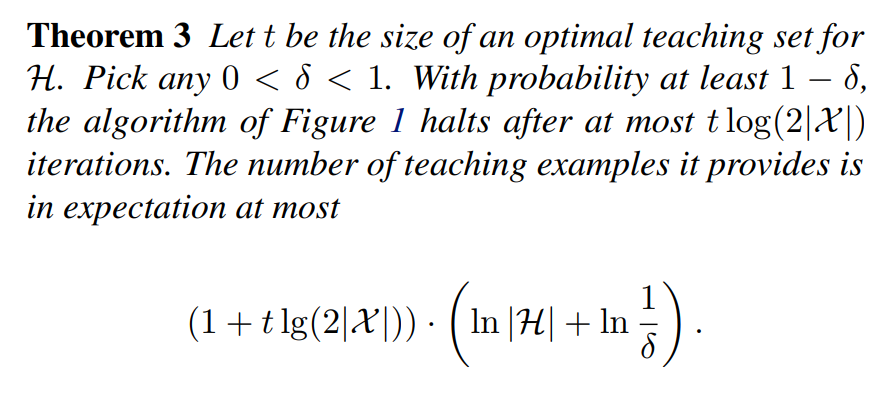

In [13]:
from torch.utils.data import Dataset
from utils import create_datasets
from torch import nn
from transformers import (AutoModelForSequenceClassification,
                          AutoTokenizer)
import torch
from datasets import Dataset as HFDataset

class ActiveLearningModel(nn.Module):
    def __init__(self, model_id, tok, teacher):
        super().__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(model_id)
        self.tok = tok
        self.teacher = teacher

    def forward(self,
                input_ids: torch.Tensor,
                attention_mask: torch.Tensor,
                labels=None) -> torch.Tensor:
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)

        ## send to teacher model
        self.teacher.update(output.logits)

        return output


class MyDataset(Dataset):

    def __init__(self, data, tokenizer, max_length, device) -> None:
        super().__init__()
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

    def __len__(self):
        # Return the total number of samples in your dataset
        return len(self.data)


    def __getitem__(self, idx):
        # Retrieve and preprocess a single sample at the given index

        sample = self.data[idx]

        # Use the tokenizer to tokenize the input text
        inputs = self.tokenizer(
            sample["tweet"],
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )

        # You might want to include other information such as labels
        labels = sample["labels"]

        # Return a dictionary containing the input_ids, attention_mask, and labels
        return {
            "input_ids": inputs["input_ids"].squeeze(0).to(self.device),
            "attention_mask": inputs["attention_mask"].squeeze(0).to(self.device),
            "labels": torch.tensor(labels).to(self.device),
        }

class TeacherDataset(MyDataset):
    def __init__(self, data, tokenizer, max_length, device, T):
        # self.data = self.load_data()
        super().__init__(data, tokenizer, max_length, device)
        self.T = T
        self.allHs = torch.tensor([]).to(self.device)



    def update(self, past_logits, automatic_new_iter=False):
        Ps = torch.softmax(past_logits, dim=0)
        nHs = (-Ps * torch.log(Ps)).sum(dim=-1).reshape((-1,))
        if(len(self.allHs) + len(nHs) <= len(self.data)): ## test data
          self.allHs = torch.cat([self.allHs, nHs])
          if(automatic_new_iter and (self.allHs.size()[0] == len(self.data))):
              self.new_iter()

    def new_iter(self):
        selected_idx = self.allHs.argsort()[-int(len(self.allHs) / 2):] ## take the sample above the entropy median
        print(selected_idx)
        print(len(selected_idx))
        print("> TEACHER ROUND, from", len(self.data), "samples to", len(selected_idx))
        self.data = HFDataset.from_dict(self.data[selected_idx.tolist()])
        print(self.data)
        self.allHs = torch.tensor([]).to(self.device)

        if(len(self.data) < self.T):
          print(f"Threshold was set at T = {self.T}, {len(self.data)} remaining datapoints, halting.")
          self.data = HFDataset.from_dict({}) ## empty dataset ===> halt

In [17]:
from utils import create_datasets


BERT_MODEL = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(BERT_MODEL)
ds = create_datasets(sub_sampling=5) ## small dataset for testing

teacher = TeacherDataset(ds,
                         tokenizer=tok,
                         max_length=512,
                         device="cpu",
                         T=2)

test_data = MyDataset(create_datasets(sub_sampling=5), tokenizer=tok, max_length=512, device="cpu")

In [18]:
model = ActiveLearningModel(BERT_MODEL, tok=tok, teacher=teacher)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

In [19]:
from transformers import TrainingArguments, Trainer
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)



class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        labels = labels.long()
        # forward pass
        outputs = model(input_ids=inputs["input_ids"],
                        attention_mask=inputs["attention_mask"])
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, labels.long())
        return (loss, outputs) if return_outputs else loss


while(len(teacher) != 0):
  ## train for 1 epoch = 1 round of the DataLoader
  training_args = TrainingArguments(
      output_dir="test_active_learning",
      learning_rate=2e-5,
      per_device_train_batch_size=16,
      per_device_eval_batch_size=16,
      num_train_epochs=1, ## only 1 epoch
      weight_decay=0.01,
      evaluation_strategy="epoch",
      save_strategy="epoch",
      remove_unused_columns=False
  )

  trainer = CustomTrainer(
      model=model,
      args=training_args,
      train_dataset=teacher,
      eval_dataset=test_data,
      tokenizer=tok,
      compute_metrics=compute_metrics
  )

  trainer.train()
  print("FINISHED EPOCH 1 ==> updating")
  teacher.new_iter() ## teacher round

c:\Users\antom\miniconda3\envs\nlpa3\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


> TEACHER ROUND, from 5 samples to 2


  0%|          | 0/3 [00:00<?, ?it/s]

{'eval_loss': 0.7029610872268677, 'eval_accuracy': 0.2, 'eval_runtime': 4.5682, 'eval_samples_per_second': 1.095, 'eval_steps_per_second': 0.657, 'epoch': 1.0}
{'train_runtime': 59.662, 'train_samples_per_second': 0.084, 'train_steps_per_second': 0.05, 'train_loss': 0.7021281719207764, 'epoch': 1.0}


TrainOutput(global_step=3, training_loss=0.7021281719207764, metrics={'train_runtime': 59.662, 'train_samples_per_second': 0.084, 'train_steps_per_second': 0.05, 'train_loss': 0.7021281719207764, 'epoch': 1.0})

In [12]:
HFDataset.from_dict({})

Dataset({
    features: [],
    num_rows: 0
})